In [1]:
#installing helper and findspark 
! pip install mllib
! pip install helper
! pip install findspark
! pip install Faker
import findspark
findspark.init()

In [2]:
#importing ML libraries
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
import json
import csv
import random

In [4]:
import numpy as np
import pandas as pd

In [58]:
##Reading csv's into pandas df

flightsCSV = pd.read_csv('606_flights.csv')
flightsCSV.head(210)

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,2015,1,1,4,AA,304,N4XHAA,SLC,DFW,600,...,1002.0,12.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
206,2015,1,1,4,AA,175,N3EWAA,DCA,DFW,600,...,NaN,NaN,0,1,B,NaN,NaN,NaN,NaN,NaN
207,2015,1,1,4,AA,281,N3FXAA,MIA,DFW,600,...,813.0,-1.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
208,2015,1,1,4,AA,233,N3BEAA,BWI,MIA,600,...,914.0,31.0,0,0,NaN,0.0,0.0,31.0,0.0,0.0


In [42]:
flightsCSV.shape

(5819079, 31)

In [47]:
## filtering to see where cancelled = 1
df_filtered = flightsCSV[flightsCSV['CANCELLED'] >= 1]
df_filtered

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
32,2015,1,1,4,AS,136,N431AS,ANC,SEA,135,...,NaN,NaN,0,1,A,NaN,NaN,NaN,NaN,NaN
42,2015,1,1,4,AA,2459,N3BDAA,PHX,DFW,200,...,NaN,NaN,0,1,B,NaN,NaN,NaN,NaN,NaN
68,2015,1,1,4,OO,5254,N746SK,MAF,IAH,510,...,NaN,NaN,0,1,B,NaN,NaN,NaN,NaN,NaN
82,2015,1,1,4,MQ,2859,N660MQ,SGF,DFW,525,...,NaN,NaN,0,1,B,NaN,NaN,NaN,NaN,NaN
90,2015,1,1,4,OO,5460,N583SW,RDD,SFO,530,...,NaN,NaN,0,1,A,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5818090,2015,12,31,4,UA,1789,NaN,IAH,TPA,1955,...,NaN,NaN,0,1,A,NaN,NaN,NaN,NaN,NaN
5818157,2015,12,31,4,UA,222,NaN,SFO,LAX,2000,...,NaN,NaN,0,1,A,NaN,NaN,NaN,NaN,NaN
5818318,2015,12,31,4,AA,2245,N880AA,MIA,SAN,2019,...,NaN,NaN,0,1,A,NaN,NaN,NaN,NaN,NaN
5818777,2015,12,31,4,NK,416,N522NK,FLL,IAG,2155,...,NaN,NaN,0,1,A,NaN,NaN,NaN,NaN,NaN


In [49]:
## number of rows that should be dropped
df_filtered.shape

(89884, 31)

In [59]:
##After ACTUALLY dropping tables
filtered = flightsCSV.drop(flightsCSV[flightsCSV['CANCELLED'] >= 1].index)
filtered.head(210)

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,2015,1,1,4,AA,1084,N3GFAA,MIA,LGA,600,...,846.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
219,2015,1,1,4,AA,1088,N201AA,LAS,DFW,600,...,1047.0,7.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
220,2015,1,1,4,AA,1534,N4YPAA,PDX,DFW,600,...,1142.0,-3.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
221,2015,1,1,4,AA,1573,N467AA,TPA,DFW,600,...,730.0,-20.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
#total number of rows after data was dropped.
filtered.shape

(5729195, 31)

In [72]:
uflights = filtered.drop(['CANCELLATION_REASON', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'AIR_SYSTEM_DELAY', 'LATE_AIRCRAFT_DELAY'], axis = 1) 
uflights


,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5819074,2015,12,31,4,B6,688,N657JB,LAX,BOS,2359,...,272.0,2611,749.0,4.0,819,753.0,-26.0,0,0,NaN
5819075,2015,12,31,4,B6,745,N828JB,JFK,PSE,2359,...,195.0,1617,427.0,3.0,446,430.0,-16.0,0,0,NaN
5819076,2015,12,31,4,B6,1503,N913JB,JFK,SJU,2359,...,197.0,1598,424.0,8.0,440,432.0,-8.0,0,0,NaN
5819077,2015,12,31,4,B6,333,N527JB,MCO,SJU,2359,...,144.0,1189,327.0,3.0,340,330.0,-10.0,0,0,NaN


In [70]:
uflights.isnull().sum() 

YEAR                         0
MONTH                        0
DAY                          0
DAY_OF_WEEK                  0
AIRLINE                      0
FLIGHT_NUMBER                0
TAIL_NUMBER                  0
ORIGIN_AIRPORT               0
DESTINATION_AIRPORT          0
SCHEDULED_DEPARTURE          0
DEPARTURE_TIME               0
DEPARTURE_DELAY              0
TAXI_OUT                     0
WHEELS_OFF                   0
SCHEDULED_TIME               1
ELAPSED_TIME             15187
AIR_TIME                 15187
DISTANCE                     0
WHEELS_ON                 2629
TAXI_IN                   2629
SCHEDULED_ARRIVAL            0
ARRIVAL_TIME              2629
ARRIVAL_DELAY            15187
DIVERTED                     0
CANCELLED                    0
WEATHER_DELAY          4665756
dtype: int64

In [161]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [162]:
df3 = pd.DataFrame(np.random.randn(12, 2), columns=['ARRIVAL_DELAY', 'AIRLINE']).cumsum()

df3['MONTH'] = pd.Series(list(range(len(uflights))))

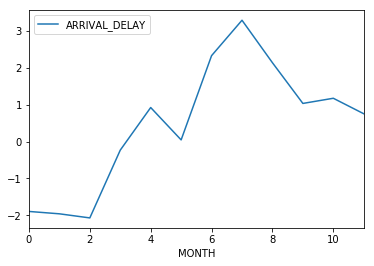

In [163]:
df3.plot(x='MONTH', y='ARRIVAL_DELAY')

In [149]:
#define a function that counts the number of times each genre appear:
def count_word(df, ref_col, liste):
    keyword_count = dict()
    for s in liste: keyword_count[s] = 0
    for liste_keywords in df[ref_col].str.split('|'):
        if type(liste_keywords) == float and pd.isnull(liste_keywords): continue
        for s in liste_keywords: 
            if pd.notnull(s): keyword_count[s] += 1
    # convert the dictionary in a list to sort the keywords  by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

In [150]:
import pandas as pd # pandas is a data manipulation library
import numpy as np #provides numerical arrays and functions to manipulate the arrays efficiently
import random
import matplotlib.pyplot as plt # data visualization library
from wordcloud import WordCloud, STOPWORDS #used to generate world cloud

data= pd.read_csv('flights.csv')

In [151]:
#here we  make census of the genres:
airline_label = set()
for s in flights['AIRLINE'].str.split('|').values:
    airline_label = airline_label.union(set(s))

In [152]:
#counting how many times each of genres occur:
keyword_occurences, dum = count_word(flights, 'AIRLINE', airline_label)
keyword_occurences

[['WN', 1261855],
 ['DL', 875881],
 ['AA', 725984],
 ['OO', 588353],
 ['EV', 571977],
 ['UA', 515723],
 ['MQ', 294632],
 ['B6', 267048],
 ['US', 198715],
 ['AS', 172521],
 ['NK', 117379],
 ['F9', 90836],
 ['HA', 76272],
 ['VX', 61903]]

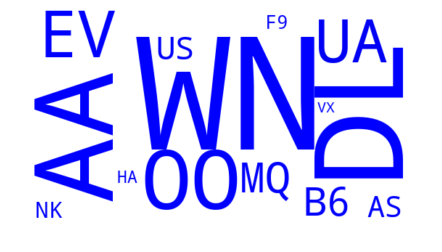

In [153]:
def colorDefine(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 155.0)
    s = int(100.0 * 255.0 / 100.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)


words = dict()
trunc_occurences = keyword_occurences[0:50]
for s in trunc_occurences:
    words[s[0]] = s[1]
f, ax = plt.subplots(figsize=(10, 4))
tone = 100
wordcloud = WordCloud(width=550,height=300, background_color='white', 
                      max_words=1628,relative_scaling=0.7,
                      color_func = colorDefine,
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(words)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

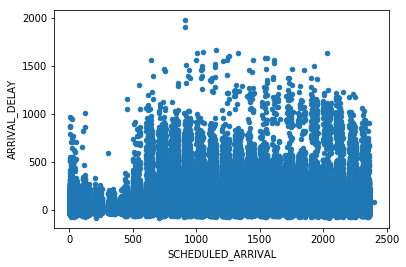

In [168]:
scatterplot = uflights.plot(kind='scatter', x='SCHEDULED_ARRIVAL', y='ARRIVAL_DELAY' )

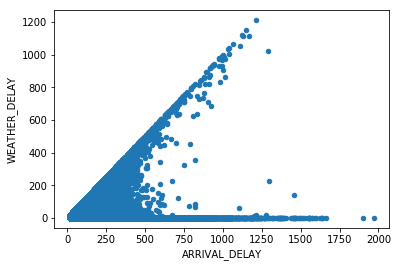

In [169]:
scatterplot = uflights.plot(kind='scatter', x='ARRIVAL_DELAY', y='WEATHER_DELAY' )

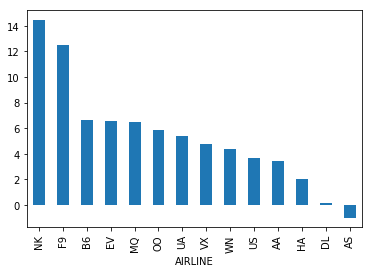

In [171]:
#average arrival_delays by airline

uflights.groupby("AIRLINE").ARRIVAL_DELAY.mean().sort_values(ascending=False)[:14].plot.bar()

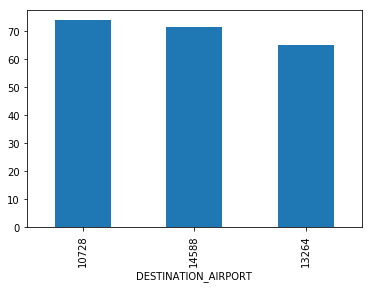

In [176]:
#average arrival_delays by airline

uflights.groupby("DESTINATION_AIRPORT").ARRIVAL_DELAY.mean().sort_values(ascending=False)[:3].plot.bar()